In [4]:
# This is the last tutorial. Congratulations.

# In this tutorial, we will investigate the different the sources of temperature change during extreme heat events

# load in the necessary libraries
import scipy.io as scp
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import numpy as np
import datetime as dt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


#Initialization Parameters
#############
locname='NYC' #name of location of focus
runname='CTL_V2' #name of model run being examined
lonwant=360-74 # NY is 74 West longitude, but the longitude dimension goes from 0 to 360, so we do 360-74
latwant=40.71
directoryt = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_LEVEL/DAILY/' #directory for temp, psl, and zg data

savename=locname + '_hwstardates_and_durations_' + runname + '.nc' #what to call the heatwave file you save
filename = 'atmos_level.*.temp.0998SigmahPa.daily.nc'


hwdatesfile='/home/Veeshan.Narinesingh/INTERNS_2024/TUTORIALS/NYC_hwstardates_and_durations_CTL_V2.nc'

#load in the temperature data; note for ERA5 we looked at 41 years of data, for AM4 we will look at a 50 year simulation 
ds = xr.open_mfdataset(directoryt + filename) 
var1 = ds.temp
lat = ds.lat
lon = ds.lon
time = ds.time

In [5]:
# Now let's calculate the temperature anomaly at all points
ny1=2;
ny2=51
nyrs=ny2-ny1+1

var1smooth5=var1.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
var1smooth5np=var1smooth5.values.reshape((nyrs,365,180,288))
var1smooth5rs= xr.DataArray(data=var1smooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
var1smooth5rs15day1=var1smooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
var1smooth5rs15day2=var1smooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
clim=var1smooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anom=var1smooth5rs-clim
anomrs= anom.values.reshape(nyrs * 365, 180, 288)


In [7]:
# now let's load in the heat extreme start dates that we calculated in the previous lesson 
hwdatesfilexr = xr.open_dataset(hwdatesfile) 

startdates = hwdatesfilexr.event_startdates
durations = hwdatesfilexr.event_durations
numevents=len(durations)
tophowmany=numevents // 2 # this divides a number by two and rounds down

# next find the indices of the start dates of just the top events
# get indices for top events only
durationssortidx=np.argsort(-durations)
durationssort=durations[durationssortidx]

startdatesxr=xr.DataArray(data=startdates)
startdatesxrwant=startdatesxr[durationssortidx[0:tophowmany]]

indices = [0] * startdatesxrwant # preallocate 
for i in range(0,np.size(startdatesxrwant)):
    indices.values[i] = np.where(time == startdatesxrwant.values[i])[0]

In [9]:
# We will now begin to plot the temperature tendency (change in Temperature with respect to time) budget:
# dT/dt = advection + latent heating + shortwave radiation  + longwave radiation  + vertical diffusion 

danomrsdt=np.gradient(anomrs,axis=0) # first calculate dT/dt, change in Temperature with respect to time

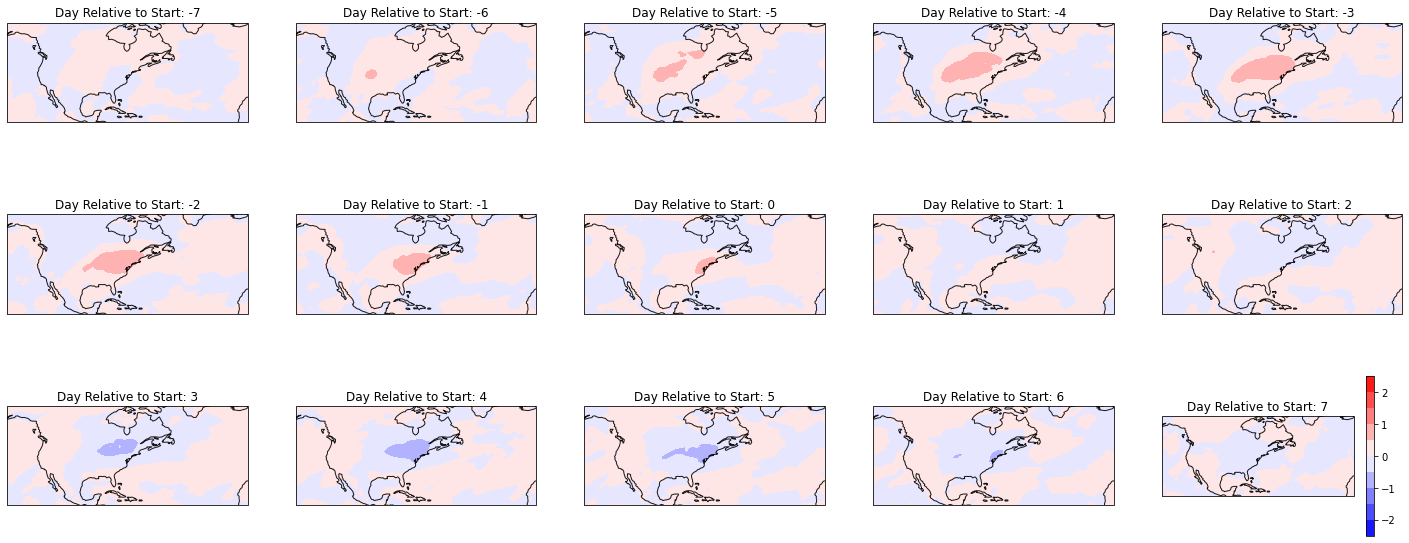

In [22]:
# set temperature contours
tmax=2.5
tmin=-tmax
numcolors=11
tempcontoursf=np.linspace(tmin,tmax,numcolors)

#set plot limits
plotlims=[lonwant-60,lonwant+60,latwant-25,latwant+25]



# Plot dT/dt (the units are K/day)
counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = danomrsdt[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf)
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)

# Does the output of these plots make sense according to your plots of the temperature evolution from Cell 14 of Lesson 03-02?

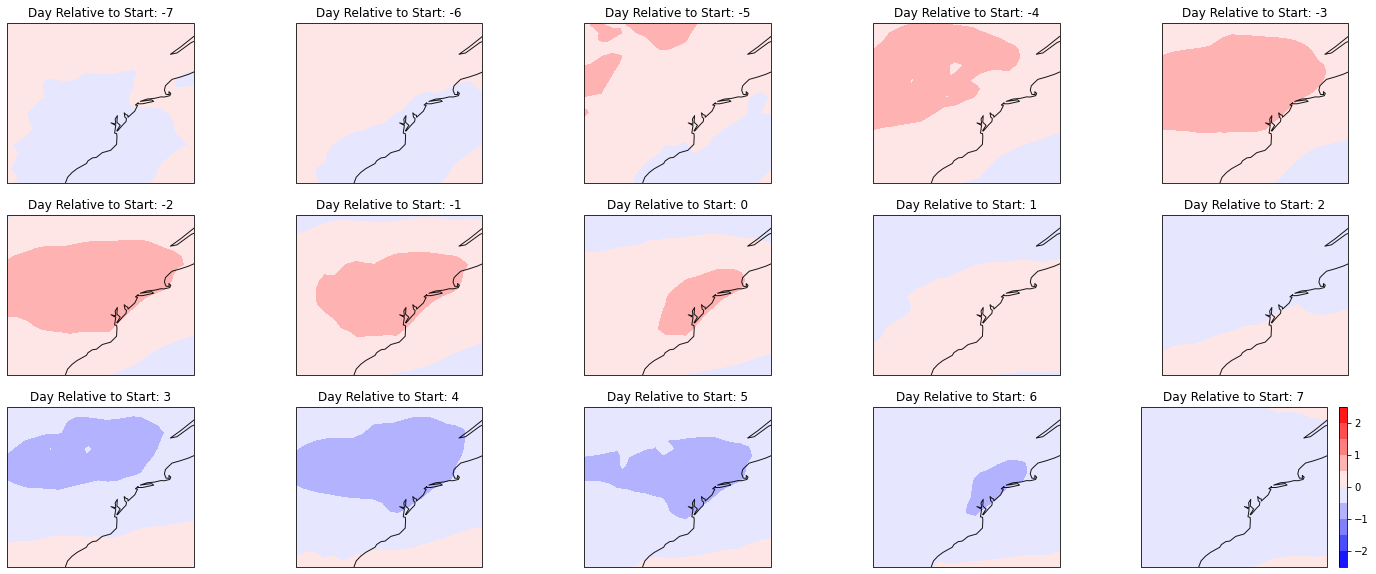

In [23]:
# Let's zoom in now and now work towards getting a better sense of the thermodynamic processes involved
plotlims=[lonwant-15,lonwant+5,latwant-10,latwant+10]



# Plot dT/dt (the units are K/day)
counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = danomrsdt[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf)
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)



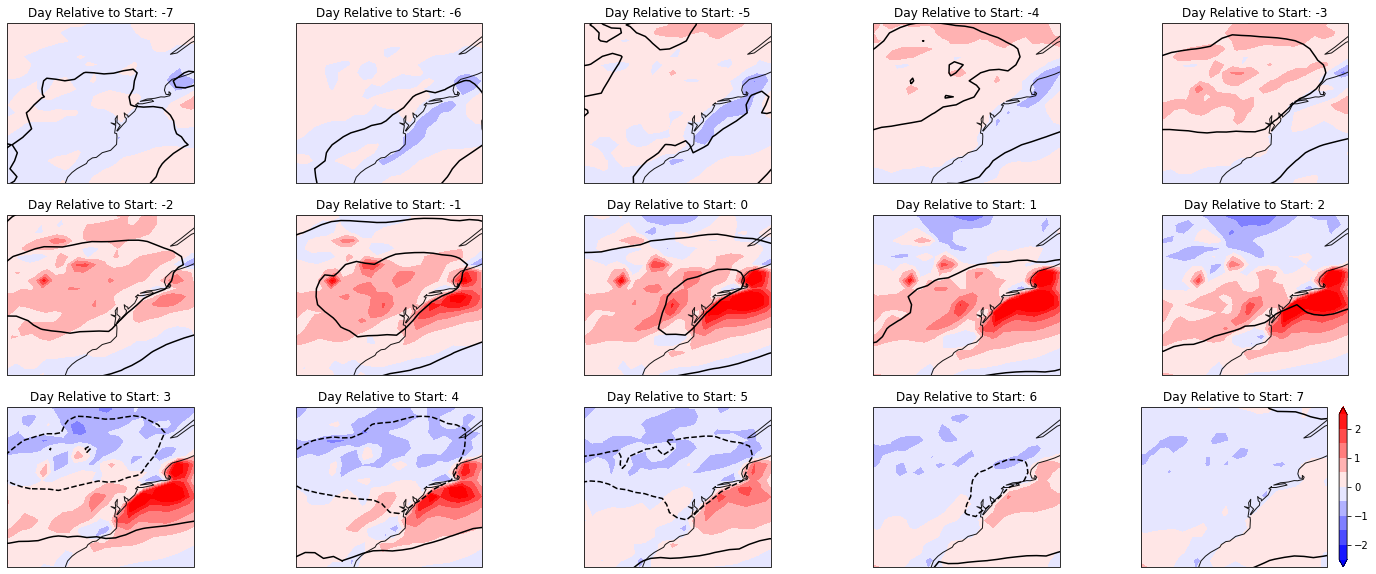

In [32]:
# Now we'll plot each term in the Temperature Tendency Budget 
dTdtlvlspos=np.arange(.00001,2.5,.5) # define the contour levels for plottign dT/dt in contours and each term in the budget in colors
dTdtlvlsneg=np.arange(-2.5,-.00001,.5)

#  dTdt: advection term 

directorydyn = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_LEVEL/DAILY/' #directory for temp, psl, and zg data
filenamedyn = 'atmos_level.*.tdt_dyn.0998SigmahPa.daily.nc'


dsdyn = xr.open_mfdataset(directorydyn + filenamedyn)
vardyn = dsdyn.tdt_dyn

vardynsmooth5=vardyn.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
vardynsmooth5np=vardynsmooth5.values.reshape((50,365,180,288))
vardynsmooth5rs= xr.DataArray(data=vardynsmooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
vardynsmooth5rs15day1=vardynsmooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
vardynsmooth5rs15day2=vardynsmooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
climdyn=vardynsmooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anomdyn=vardynsmooth5rs-climdyn

# reshape the array back to days,lat,lon from years,days,lat,lon
anomrsdyn= anomdyn.values.reshape(50 * 365, 180, 288)

counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = anomrsdyn[indices + t,:,:].mean(axis=0)*86400 #multiply by 86400 to get K / day
    compdt = danomrsdt[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plottopos=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlspos,linestyles='solid',colors='black')
    plottoneg=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlsneg,linestyles='dashed',colors='black')
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf, extend="both")
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)

del vardynsmooth5, vardynsmooth5np, vardynsmooth5rs, vardynsmooth5rs15day1, vardynsmooth5rs15day2, climdyn, anomdyn, anomrsdyn, vardyn


# Where and when is this term acting to warm things up? Where and when is it acting to cool things off?

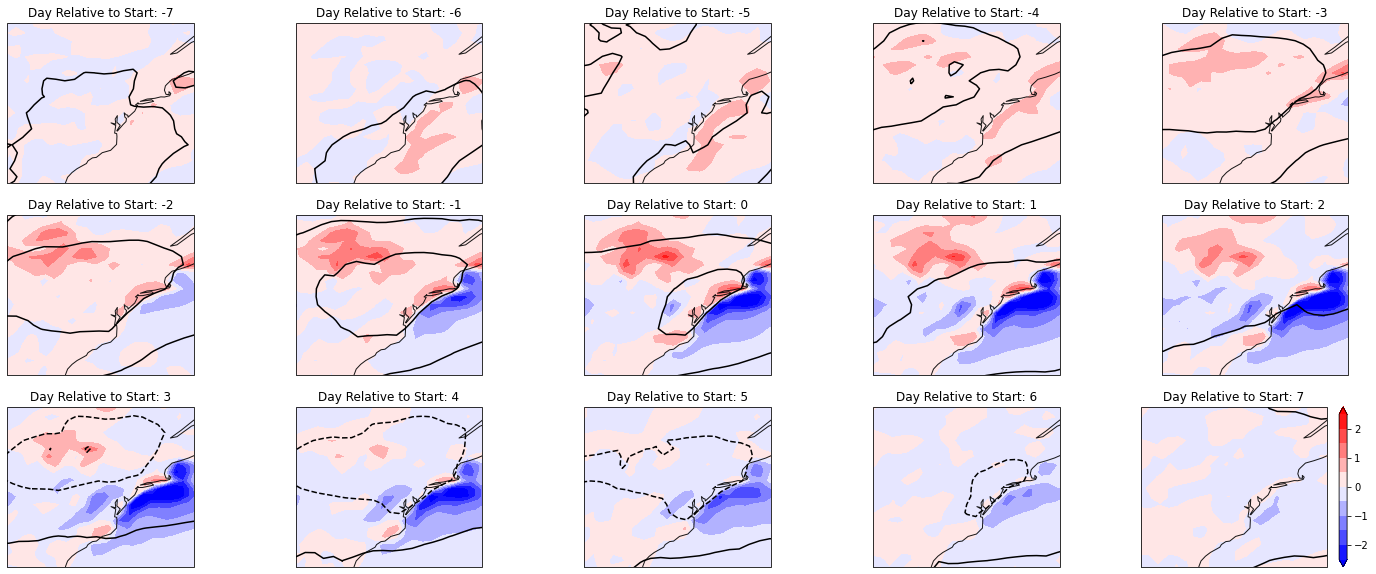

In [34]:
#  dTdt: vertical diffusion

directoryvdif = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_LEVEL/DAILY/' #directory for temp, psl, and zg data
filenamevdif = 'atmos_level.*.tdt_vdif.0998SigmahPa.daily.nc'


dsvdif = xr.open_mfdataset(directoryvdif + filenamevdif)
varvdif = dsvdif.tdt_vdif

varvdifsmooth5=varvdif.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
varvdifsmooth5np=varvdifsmooth5.values.reshape((50,365,180,288))
varvdifsmooth5rs= xr.DataArray(data=varvdifsmooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
varvdifsmooth5rs15day1=varvdifsmooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
varvdifsmooth5rs15day2=varvdifsmooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
climvdif=varvdifsmooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anomvdif=varvdifsmooth5rs-climvdif

# reshape the array back to days,lat,lon from years,days,lat,lon
anomrsvdif= anomvdif.values.reshape(50 * 365, 180, 288)

counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = anomrsvdif[indices + t,:,:].mean(axis=0)*86400 #multiply by 86400 to get K / day
    compdt = danomrsdt[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plottopos=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlspos,linestyles='solid',colors='black')
    plottoneg=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlsneg,linestyles='dashed',colors='black')
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf, extend="both")
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)

del varvdifsmooth5, varvdifsmooth5np, varvdifsmooth5rs, varvdifsmooth5rs15day1, varvdifsmooth5rs15day2, climvdif, anomvdif, anomrsvdif, varvdif


# Where and when is this term acting to warm things up? Where and when is it acting to cool things off?

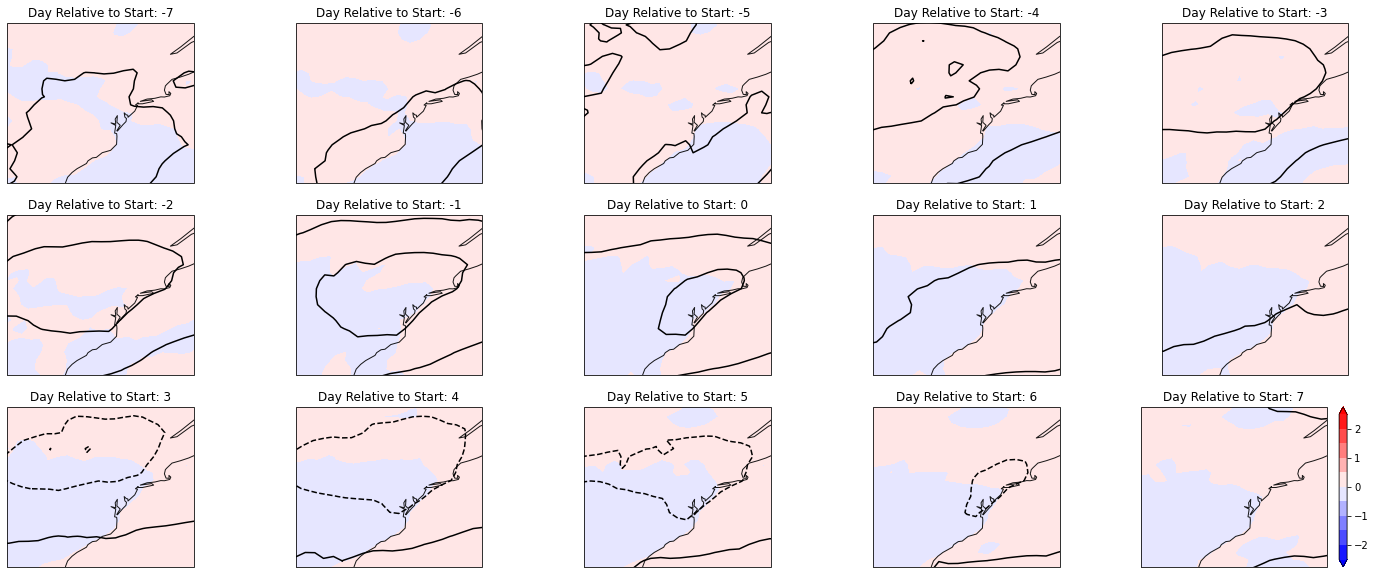

In [35]:
#  dTdt: latent heating from subgridscale convection

directoryconv = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_LEVEL/DAILY/' #directory for temp, psl, and zg data
filenameconv = 'atmos_level.*.tdt_conv.0998SigmahPa.daily.nc'


dsconv = xr.open_mfdataset(directoryconv + filenameconv)
varconv = dsconv.tdt_conv

varconvsmooth5=varconv.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
varconvsmooth5np=varconvsmooth5.values.reshape((50,365,180,288))
varconvsmooth5rs= xr.DataArray(data=varconvsmooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
varconvsmooth5rs15day1=varconvsmooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
varconvsmooth5rs15day2=varconvsmooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
climconv=varconvsmooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anomconv=varconvsmooth5rs-climconv

# reshape the array back to days,lat,lon from years,days,lat,lon
anomrsconv= anomconv.values.reshape(50 * 365, 180, 288)

counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = anomrsconv[indices + t,:,:].mean(axis=0)*86400 #multiply by 86400 to get K / day
    compdt = danomrsdt[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plottopos=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlspos,linestyles='solid',colors='black')
    plottoneg=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlsneg,linestyles='dashed',colors='black')
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf, extend="both")
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)

del varconvsmooth5, varconvsmooth5np, varconvsmooth5rs, varconvsmooth5rs15day1, varconvsmooth5rs15day2, climconv, anomconv, anomrsconv, varconv


# Where and when is this term acting to warm things up? Where and when is it acting to cool things off?

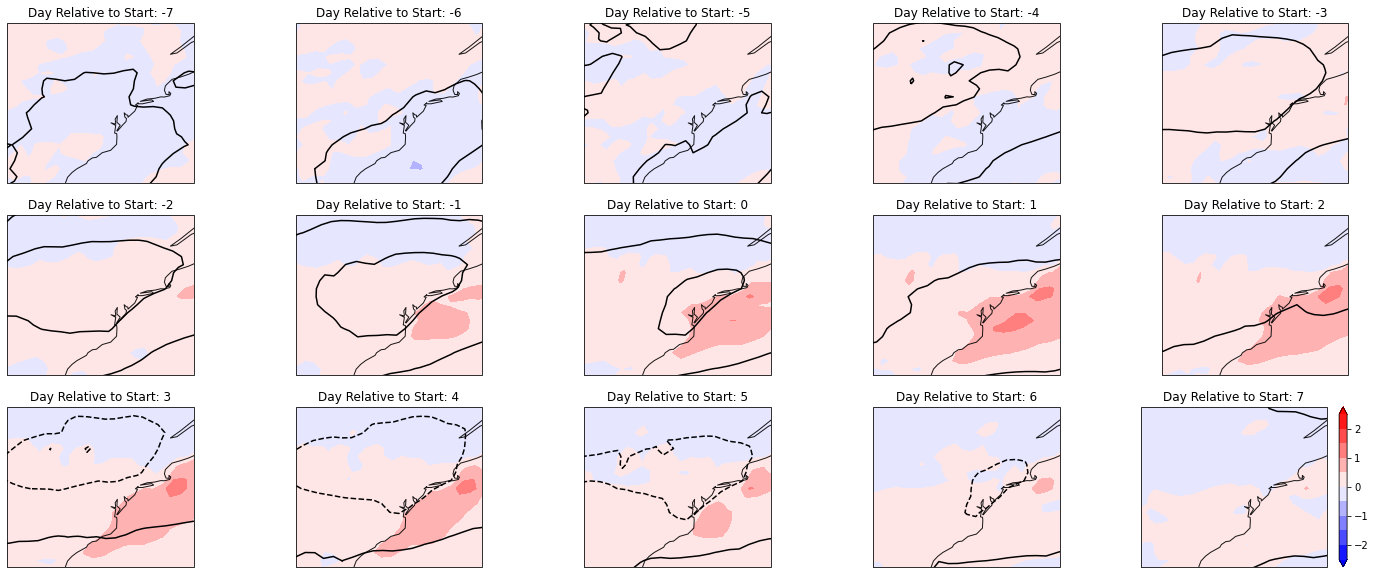

In [36]:
#  dTdt: latent heating from large-scale convection 

directoryls = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_LEVEL/DAILY/' #directory for temp, psl, and zg data
filenamels = 'atmos_level.*.tdt_ls.0998SigmahPa.daily.nc'


dsls = xr.open_mfdataset(directoryls + filenamels)
varls = dsls.tdt_ls

varlssmooth5=varls.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
varlssmooth5np=varlssmooth5.values.reshape((50,365,180,288))
varlssmooth5rs= xr.DataArray(data=varlssmooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
varlssmooth5rs15day1=varlssmooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
varlssmooth5rs15day2=varlssmooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
climls=varlssmooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anomls=varlssmooth5rs-climls

# reshape the array back to days,lat,lon from years,days,lat,lon
anomrsls= anomls.values.reshape(50 * 365, 180, 288)

counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = anomrsls[indices + t,:,:].mean(axis=0)*86400 #multiply by 86400 to get K / day
    compdt = danomrsdt[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plottopos=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlspos,linestyles='solid',colors='black')
    plottoneg=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlsneg,linestyles='dashed',colors='black')
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf, extend="both")
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)

del varlssmooth5, varlssmooth5np, varlssmooth5rs, varlssmooth5rs15day1, varlssmooth5rs15day2, climls, anomls, anomrsls, varls


# Where and when is this term acting to warm things up? Where and when is it acting to cool things off?

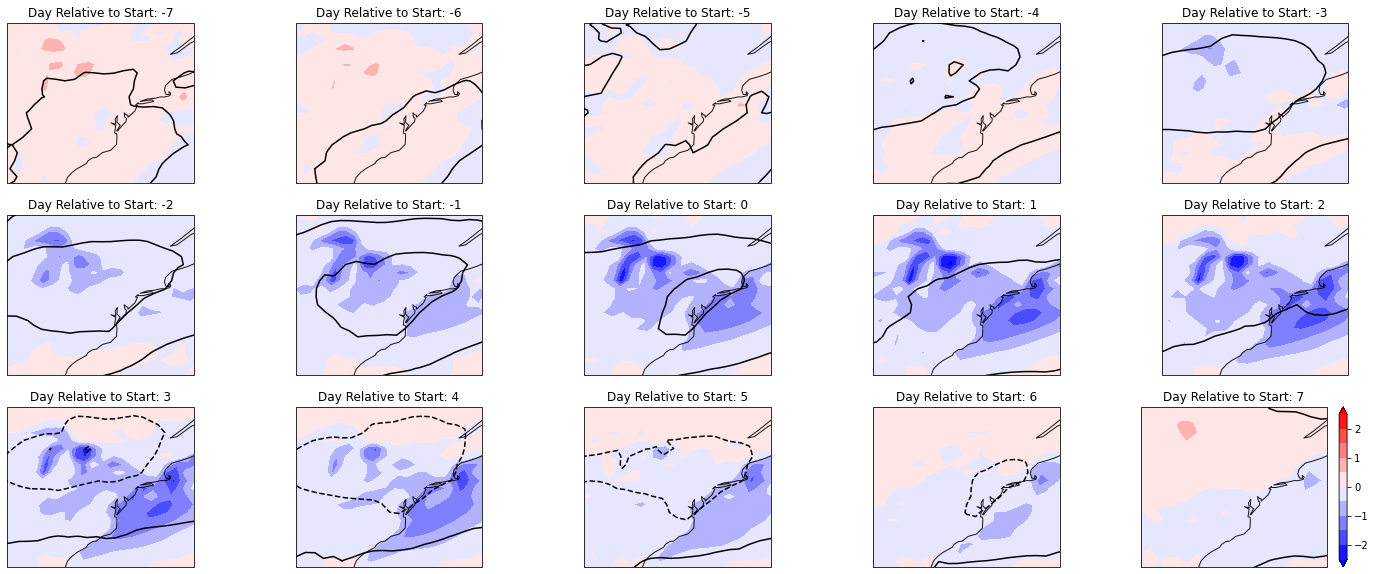

In [37]:
#  dTdt: Long-wave Radiation 

directorylw = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_LEVEL/DAILY/' #directory for temp, psl, and zg data
filenamelw = 'atmos_level.*.tdt_lw.0998SigmahPa.daily.nc'


dslw = xr.open_mfdataset(directorylw + filenamelw)
varlw = dslw.tdt_lw

varlwsmooth5=varlw.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
varlwsmooth5np=varlwsmooth5.values.reshape((50,365,180,288))
varlwsmooth5rs= xr.DataArray(data=varlwsmooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
varlwsmooth5rs15day1=varlwsmooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
varlwsmooth5rs15day2=varlwsmooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
climlw=varlwsmooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anomlw=varlwsmooth5rs-climlw

# reshape the array back to days,lat,lon from years,days,lat,lon
anomrslw= anomlw.values.reshape(50 * 365, 180, 288)

counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = anomrslw[indices + t,:,:].mean(axis=0)*86400 #multiply by 86400 to get K / day
    compdt = danomrsdt[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plottopos=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlspos,linestyles='solid',colors='black')
    plottoneg=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlsneg,linestyles='dashed',colors='black')
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf, extend="both")
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)

del varlwsmooth5, varlwsmooth5np, varlwsmooth5rs, varlwsmooth5rs15day1, varlwsmooth5rs15day2, climlw, anomlw, anomrslw, varlw


# Where and when is this term acting to warm things up? Where and when is it acting to cool things off?

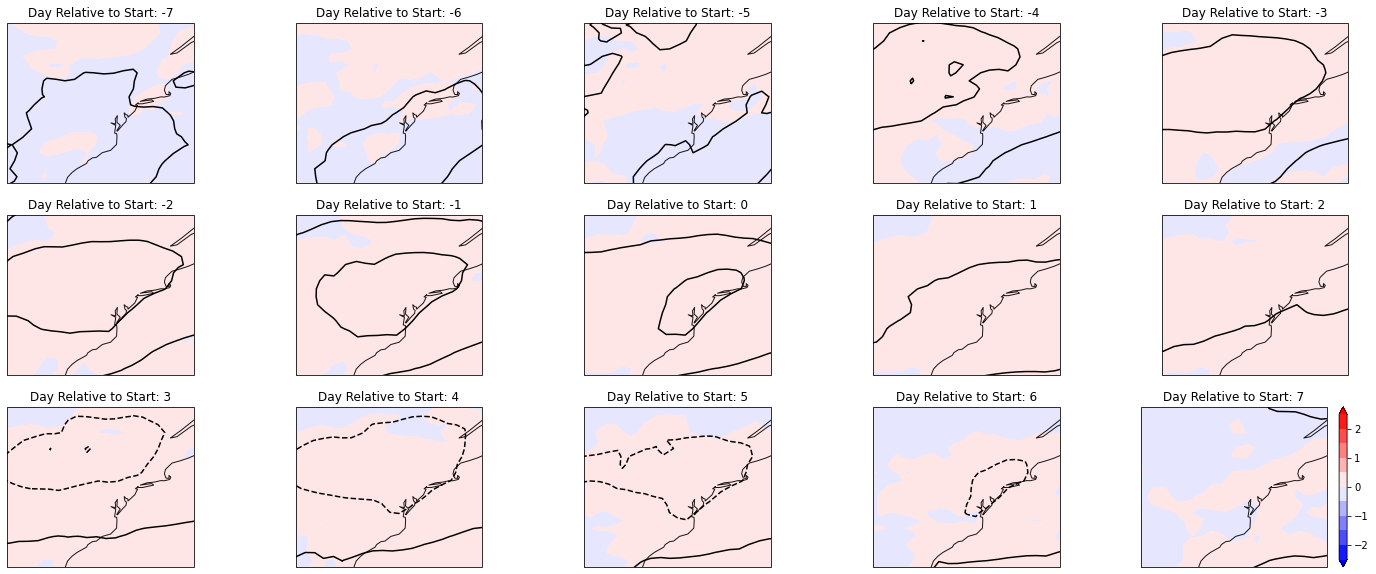

In [38]:

#  dTdt: Short-wave radiation 

directorysw = '/work/Veeshan.Narinesingh/EXTREME_HEAT_EVENTS_TdT_ANALYSIS/' + runname + '/ATMOS_LEVEL/DAILY/' #directory for temp, psl, and zg data
filenamesw = 'atmos_level.*.tdt_sw.0998SigmahPa.daily.nc'


dssw = xr.open_mfdataset(directorysw + filenamesw)
varsw = dssw.tdt_sw

varswsmooth5=varsw.rolling(time=5,center=True,min_periods=1).mean()#5 day smooth using running mean
varswsmooth5np=varswsmooth5.values.reshape((50,365,180,288))
varswsmooth5rs= xr.DataArray(data=varswsmooth5np,dims=["year","day","lat","lon"],coords=dict(year=np.arange(2,52,1),day=np.arange(1,366,1)))
varswsmooth5rs15day1=varswsmooth5rs.rolling(day=15,center=True,min_periods=1).mean()#1st 15 day running mean 
varswsmooth5rs15day2=varswsmooth5rs15day1.rolling(day=15,center=True,min_periods=1).mean()#2nd 15 day running mean
climsw=varswsmooth5rs15day2.rolling(year=11,center=True,min_periods=1).mean()#29 day by 11 year climatology
anomsw=varswsmooth5rs-climsw

# reshape the array back to days,lat,lon from years,days,lat,lon
anomrssw= anomsw.values.reshape(50 * 365, 180, 288)

counter=1 #start a figure counter 
fig=plt.figure(figsize=(25,10)) #specify the figure size
for t in range(-7,8): # start a loop that will go from -7 days before the start dates to +7 after

    # composite relative to the start date, 0 is on the start dates, -1 is 1 day before +1 is 1 day after
    comp = anomrssw[indices + t,:,:].mean(axis=0)*86400 #multiply by 86400 to get K / day
    compdt = danomrsdt[indices + t,:,:].mean(axis=0)


    #plot  composite 
    ax = fig.add_subplot(3, 5, counter, projection=ccrs.EckertIII()) # specifying a subplot with 3 rows and 5 columns
    ax.set_global()
    ax.coastlines('110m', alpha=0.9) #alpha is how dark lines are
    plottopos=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlspos,linestyles='solid',colors='black')
    plottoneg=ax.contour(lon,lat,compdt,transform=ccrs.PlateCarree(),levels=dTdtlvlsneg,linestyles='dashed',colors='black')
    plotto=ax.contourf(lon,lat,comp,transform=ccrs.PlateCarree(),cmap='bwr',levels=tempcontoursf, extend="both")
    #fig.colorbar(plotto)
    ax.set_extent(plotlims,crs=ccrs.PlateCarree())
    plt.title("Day Relative to Start: " + str(t))
    counter=counter+1 # increase the fig counter by 1 each time you go through the loop
    
fig.colorbar(plotto)

del varswsmooth5, varswsmooth5np, varswsmooth5rs, varswsmooth5rs15day1, varswsmooth5rs15day2, climsw, anomsw, anomrssw, varsw


# Where and when is this term acting to warm things up? Where and when is it acting to cool things off?

In [ ]:
# Which term(s) is/are dominant in warming things up during heat extremes? What about cooling things off?

In [ ]:
# Congratulations. You have now completed the tutorial! :)

# Now the rest is up to you. You now have developed some basic skills on studying heat extremes. Now take this knowledge, figure out a question to ask and figure it out!

# One good way to start is to pick your own region of interest and repeat all the lessons for that place. 